In [1]:
from spiders import W, Z, ZBox, Id, X, Swap, H, boxes
from pyfile import eq, eval

Looking at connection between Schmidt rank and polynomial properties.


## Schmidt rank


Will represent bipartite states as $(\psi_{AB}, |A|, |B|)$ 

The following computes Schmidt rank using  $rank(\rho^A)$

In [2]:
import numpy as np

def basis(k, n, bra=False):
    xs = np.zeros((2**n, 1))
    xs[k][0] = 1
    if bra:
        return xs.transpose()
    return xs
    

def partial_trace_B(state, n_A, n_B):
    rho_state = state @ np.conj(state).T # |psi> -> |psi><psi|
    t = np.zeros((2**n_A, 2**n_A), dtype=complex)
    for j in range(2**n_B):
        kj, bj = basis(j, n_B), basis(j, n_B, True)
        t += np.kron(np.eye(2**n_A), bj) @ rho_state @ np.kron(np.eye(2**n_A), kj)
    return t

def s_rank(state, n_A=None, n_B=None): #n_A = number of A's qubits, etc
    if n_A is None and n_B is None: #make half split
        n_A = n_B = int(np.log2(state.shape[0]))//2
    if state.shape[1] == 2:
        state = state[:, 1] # if accidentally given controlled state, just choose 2nd column
    assert state.shape == (2**(n_A + n_B), 1), ("wrong sizes", n_A, n_B, state.shape)
    
    psi_A = partial_trace_B(state, n_A, n_B)
    return np.linalg.matrix_rank(psi_A)

In [3]:
bell = np.array([[1, 0, 0, 1]]).transpose()
partial_trace_B(bell, 1, 1), s_rank(bell, 1, 1)

(array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]),
 2)

In [4]:
product_state = basis(3, 2)
s_rank(product_state, 1, 1)

1

In [5]:
n = 3
rand_state = np.random.randint(-1, 2, (2**n, 1))
s_rank(rand_state, 2, 1)

2

## Poly rank

Will represent the polynomial for a bipartite state $|\psi_{AB}\rangle$ as $p(x_1, ..., x_n, y_1, ..., y_m)$ where $x$ variables correspond to $A$ and $y$ variables. 

Bipartite state $\psi_{AB}$ is seperable iff $P_\psi = p(x_1, ..., x_n) \times q(y_1, ..., y_m)$. 

The following code implements the irreducibile test for seperability:
1. Given a state $\psi_{AB}$, convert to polynomial $p_\psi$
2. Get irreducible factors $f_1, ..., f_k$ of $p_\psi$
3. Return false iff any factor $f_j$ contains both $X$ variables and $Y$ variables

In [6]:
from spiders import W, Z, ZBox, Id, X, Swap, H, boxes
from pyfile import eq, eval
from polys import get_poly, Poly, symbols
import numpy as np
coW = cow = W(2, 1, True)

In [7]:
def is_prod(state, n_A=None, n_B=None):
    if n_A is None and n_B is None: #make half split
        n_A = n_B = int(np.log2(state.shape[0]))//2
    assert 2**(n_A + n_B) == state.shape[0], ("wrong sizes", n_A, n_B, state.shape)
    
    
    poly = get_poly(state, n_A, n_B) #gets polynomial p_psi
    
    _, factors = poly.factor_list() #factors into irreducibles
    
    for f in factors:
        #if f has both x's and y's
        degrees = f[0].degree_list() #gets list of degrees of f
        if np.any(degrees[:n_A]) and np.any(degrees[n_A:]):
            return False
    return True
        

Peforms basic sanity check that polynomial seperability test agrees with Schmidt rank test defined above. All states generated with coefficients from $-1, 0, 1$ to avoid floating point errors.

In [8]:
n = 4
for _ in range(100):
    rand_state = np.random.randint(-1, 2, (2**n, 1))
    #rand_state = 2 * np.random.rand(2**n, 1) - 1
    s = s_rank(rand_state, n//2, n//2)
    if is_prod(rand_state) and s == 1:
        print("✔ both yes")
    elif not is_prod(rand_state) and s != 1:
        #print("✔ both no")
        pass
    else:
        print("\n failed on", rand_state, "\n")

### Timing analysis

Performs some basic numerics on the two algorithms to compare efficiency.

For $n=1, ... 6$, generates $k = 50$ bipartite states on $2n$ qubits: product state with probability $p_{sep} = 1/3$, random state (which is probably entangled) with probability 2/3. 

In [9]:
import time
import pandas as pd


ns = list(range(1, 7))

k = 50

p_sep = 1/3


all_times = {'method': [], 'n': [], 'time': []}

for n in ns:
    print("\n", n)
    
    for i in range(k):
        if i % 10 == 0: print(i, end=',')
        if np.random.rand() < p_sep:
            a_state = np.random.randint(-1, 2, (2**n, 1))
            b_state = np.random.randint(-1, 2, (2**n, 1))
            rand_state = np.kron(a_state, b_state)
        else:
            rand_state = np.random.randint(-1, 2, (2**(2*n), 1))
            
        a = time.time()
        s_out = s_rank(rand_state, n, n) <= 1
        b = time.time()
   
        all_times['method'].append('Schmidt')
        all_times['n'].append(n)
        all_times['time'].append(b-a)
        
        a2 = time.time()
        p_out = is_prod(rand_state, n, n)
        b2 = time.time()

        
        all_times['method'].append('Poly')
        all_times['n'].append(n)
        all_times['time'].append(b2-a2)
        
        assert s_out == p_out, ("gave different answer on", rand_state)



 1

 2

 3

 4

 5

 6


Text(0.5, 1.0, 'Numerical Comparison of Seperability Algorithms')

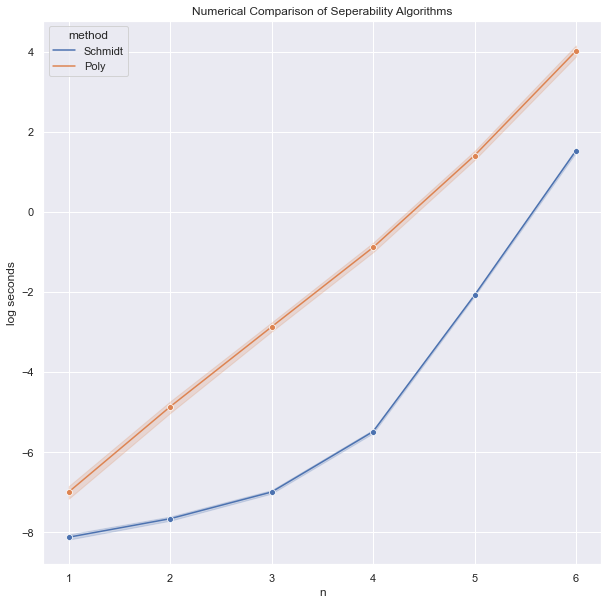

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
sns.set(rc={'figure.figsize':(10, 10)})
df = pd.DataFrame.from_dict(all_times)
df['log seconds'] = np.log(df['time'])
sns.lineplot(data=df, x="n", y="log seconds", hue='method', marker='o', ci=95)
plt.title('Numerical Comparison of Seperability Algorithms')


In [13]:
import pickle
pickle.dump(df, open('saved_times.p', 'wb'))

## Analysis

* While the Schmidt rank method is initially faster, the polynomial factorisation method seems to have slightly better scaling
* Since both algorithms rely on the entire state-vector, they both scale poorly in $n$, making them both intractable at $n$ as low as $10$.